# RAG w/Langgraph

- https://python.langchain.com/docs/tutorials/rag/

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# 1. Loader (웹문서)
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer # 웹페이지 문서 필터기 # pip install beautifulsoup4
from pprint import pprint


loader = WebBaseLoader(
    # 문서 출처 URL
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',),
    # 웹페이지 안에서 필요한 정보만 선택하기
    bs_kwargs = {
        'parse_only': SoupStrainer(class_=['post-content'])
    }
    # header_template= {}
)

docs = loader.load()
pprint(docs[0].page_content)

# 2. Splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splitted_docs = splitter.split_documents(docs)
print(len(splitted_docs))

# 3. Embedding Model
from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(model='text-embedding-3-small') # small <-> large

# 4. Vectorstore (지금은 FAISS -> 클라우드- Pinecone)
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview#\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\n'
 'Memory\n'
 '\n'
 'Short-term memory: I would consider all the in-cont

In [6]:
from langchain import hub

prompt = hub.pull('rlm/rag-prompt')
for m in prompt.messages:
    m.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [12]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4.1-nano')
# State
from langchain_core.documents import Document
from typing_extensions import TypedDict, List

class State(TypedDict):
    question: str
    context: List[Document] # RAG 데이터 문서조각/ 리스트 안에 document가 들어가야한다고 명시
    answer: str

# Node -  Edge
# 검색노드
def retrieve(state: State):
    # [Document 타입 객체 4개]
    retrieved_docs = vectorstore.similarity_search(state['question'], k=4)

    # 나머지 return하지 않은 state항목들은, 알아서 그대로 감(question, answer는 알아서 그대로 나감)
    return {'context': retrieved_docs, } 

# 답변 생성노드
def generate(state: State):
    # Document 객체의 필요없는 정보는 다 빼고, 내용에 해당하는 page_content만 모아서 넘기면 토큰 절약 가능
    context_str = ''
    for doc in state['context']:
        context_str += doc.page_content + '\n ------------------------ \n'

    question_with_context = prompt.invoke({'question': state['question'], 'context': context_str})
    response = llm.invoke(question_with_context)
    return {'answer': response.content}

# Graph
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

# 출력
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
final_state = graph.invoke({'question': '에이전트 시스템에 대해서 알려줘!'})

final_state['answer']

'에이전트 시스템은 독립적으로 환경을 인식하고 행동하며 목표를 달성하도록 설계된 소프트웨어 또는 하드웨어 시스템입니다. 이 시스템은 입력을 받아 분석 후 적절한 행동을 선택하고 수행하는 과정을 반복합니다. 주로 인공지능, 자동화, 로보틱스에서 사용되며, 자율성을 갖춘 의사결정 구조를 포함합니다.'

### 메세지 스트리밍

In [11]:
for event in graph.stream({'question': 'LangGraph란 뭐야?'}):
    for node_name, output in event.items():
        print(f"[{node_name}] {output}")

[retrieve] {'context': 'Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\n\nThe system comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.\nInstruction:\n ------------------------ \n(4) Response generation: LLM receives the execution results and provides summarized results to users.\nTo put HuggingGPT into real world usage, a couple challenges need to solve: (1) Efficiency improvement is needed as both LLM inference rounds and interactions with other models slow down the process; (2) It relies on a long context window to communicate over complicated task content; (3) Stability improvement of LLM outputs and external model services.\n ------------------------ \nBuilding agents with LLM (large language model) as its core controller is a

## RAG + a
- Metadata 편집
- Query 분석 - 보완


In [17]:
# 문서 63개중 1/3 지점
third = len(splitted_docs) // 3

# metadata 에 'section' 추가중
for idx, doc in enumerate(splitted_docs):
    if idx < third:
        doc.metadata['section'] = 'beginning'
    elif idx < third * 2:
        doc.metadata['section'] = 'middle'
    else:
        doc.metadata['section'] = 'end'

splitted_docs[0].metadata

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

In [ ]:
# State를 더 빡빡하게 정의하기 위해, 위에 따로 정의한 클래스 Search
# StructuredOutput

from typing import Literal # 말 그대로
from typing_extensions import Annotated # 할말이 좀 더 있다

class Search(TypedDict):
    """vectorstore Search Query"""
    # 1. 타입, 2. ... -> NOT NULL, 3. 설명
    query: Annotated[str, ..., 'Search query to run']
    section: Annotated[
        Literal['beginning', 'middle', 'end'],
        ...,
        'Section to query'
    ]

class MyState(TypedDict):
    question: str
    query: Search # State를 더 빡빡하게 정의하기 위해, 위에 따로 정의한 클래스  Search
    context: List[Document]
    answer: str

In [18]:
# Node
def analyze_query(state: MyState):
    # Search 클래스에 맞춰 사용자 question을  {query, section}로 바꿈
    s_llm = llm.with_structured_output(Search)
    query = s_llm.invoke(state['question'])
    return {'query': query}

def retrieve(state: MyState):
    query = state['query']
    docs = vectorstore.similarity_search(
        query['query'],
        # LLM이 판단한 section과 실제 문서조각의 section이 맞을 경우에만 검색.
        filter=lambda metadata: metadata.get('section') == query['section']
    )
    return {'context': docs}

def generate(state: MyState):
    # Token 아끼기 위해, 내용만 추려서 문자열로 만들기
    doc_str = ''
    for doc in state['context']:
        doc_str += doc.page_content + '\n===========================\n'
    question_with_context = prompt.invoke({'question': state['question'], 'context': doc_str})
    res = llm.invoke(question_with_context)
    return{'answer': res.content}

builder = StateGraph(MyState)
builder.add_node('analyze_query', analyze_query)
builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'analyze_query')
builder.add_edge('analyze_query', 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()


In [20]:
graph.invoke({'question': '작업ㅂ분배가  뭐임?'}) # 개떡같이 말해도 찰떡같이 알아들음

{'question': '작업ㅂ분배가  뭐임?',
 'query': {'query': '작업분배가 뭐임?', 'section': '중본부'},
 'context': [],
 'answer': '작업 분배는 여러 사람이나 팀이 업무를 적절하게 나누어 수행하는 것을 의미합니다. 이를 통해 효율적으로 작업을 완료하고 시간과 자원을 절약할 수 있습니다. 일반적으로 프로젝트 관리나 조직 내에서 중요하게 다뤄지는 개념입니다.'}

## 대화형 RAG

In [21]:
from dotenv import load_dotenv
load_dotenv()

True

In [59]:
# Langchain + Pinecone
%pip install -q langchain-pinecone

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# 1. Loader (웹문서)
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer  # pip install beautifulsoup4
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from dotenv import load_dotenv
load_dotenv()

loader = WebBaseLoader(
    # 문서 출처 URL
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',),
    # 웹페이지 안에서 필요한 정보만 선택하기
    bs_kwargs = {
        'parse_only': SoupStrainer(class_=['post-content'])
    }
    # header_template= {}
)

docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splitted_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings(model='text-embedding-3-small') # small <-> large

# 4. Vectorstore (지금은 FAISS -> 클라우드- Pinecone)
# pc = Pinecone()
# if pc.has_index(index_name):
#     index = pc.Index(index_name)
#     vectorstore = PineconeVectorStore(index=index, embedding=embedding)
# else:
#     print('No index name', index_name)

index_name = 'gaida-1st'
# 1회 실행하면, 실제 데이터가 들어가서 영구 저장됨.(다시 실행할 필요X)
# vectorstore = PineconeVectorStore.from_documents(
#     splitted_docs,
#     index_name=index_name,
#     embedding=embedding
# )

In [ ]:
# 기존에 존재하는 index를 불러오는 코드
vectorstore = PineconeVectorStore.from_documents(splitted_docs, index_name = index_name, embedding = embedding)

In [53]:
from langchain_core.tools import tool

@tool(response_format='content_and_artifact')  # 2개를 return 한다
def retrieve(query: str):
    """Retrieve information related to a query
    Args:
        query : Query to search
    """
    # 원본 Document list (artifact)
    docs = vectorstore.similarity_search(query, k=3)
    # 편집한 텍스트 (content)
    result_text = '\n\n'.join(
        (f'Source: {doc.metadata}\nContent: {doc.page_content}')
        for doc in docs
    )
    return result_text, docs

In [66]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START, END

llm = ChatOpenAI(model='gpt-4.1', temperature=0)

# Node
def query_or_respond(state: MessagesState):
    """도구 호출을 하거나, 최종 응답을 한다."""
    llm_with_tools = llm.bind_tools([retrieve])
    guide = SystemMessage(
        content="""
        넌 AI 어시스턴트야. 만약 사용자가 LLM이나 Agent System과 관련된 질문을 하면
        `retrieve` Tool을 사용해야해.
        """
    )
    res = llm_with_tools.invoke([guide] + state['messages'])
    return {'messages': [res]} # ai메세지를 기존 메세지 리스트에 추가하는 과정

tools = ToolNode([retrieve])

def generate(state: MessagesState):
    """응답 생성"""
    tool_messages = []
    for msg in reversed(state['messages']):  # 메세지 목록을 뒤집음: 최신 메세지부터 순회
        if msg.type == 'tool':
            tool_messages.append(msg)
        else:
            break
    tool_messages.reverse()
    docs_content = '\n\n'.join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    # 필요 없는 Tool 메세지들을 제외하고, AI, Human, System 메시지만 모아서 정리
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [67]:
from langgraph.graph import MessagesState, StateGraph

builder = StateGraph(MessagesState) # 'messages'

# builder.add_node('query_or_respond', query_or_respond)  # 아래와 같은 결과
builder.add_node(query_or_respond)
builder.add_node(tools)
builder.add_node(generate)

# builder.set_entry_point('query_or_respond')  # 아래와 같은 말
builder.add_edge(START, 'query_or_respond')
builder.add_conditional_edges(
    'query_or_respond',
    tools_condition,
    {END: END, 'tools': 'tools'}  # 정확하게 상황별 다음 Node 를 지정할 수 있음
)
builder.add_edge('tools', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

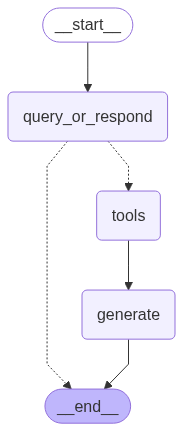

In [68]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
# 위 그래프를 실행하려면?
input_state = {
    'messages': [
        {'role': 'user', 'content': '휴리함수가 뭐야?'}
    ]
}
res = graph.invoke(input_state)

for msg in res['messages']:
    msg.pretty_print()


================================ Human Message =================================

휴리함수가 뭐야?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_qTONrFvRnGiaThtnEcV1fI8V)
 Call ID: call_qTONrFvRnGiaThtnEcV1fI8V
  Args:
    query: 휴리함수
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Illustration of the Reflexion framework. (Image source: Shinn & Labash, 2023)

The heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.
Self-reflection is created by showing two-shot examples to LLM and each example is a pair of (failed trajectory

## 대화기록 저장하기(Langgraph Memory)

In [70]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# 위에 정의된 builder 사용
graph = builder.compile(checkpointer=memory)

In [71]:
config = {
    'configurable': {'thread_id': '123'}
}

input_state = {
    'messages': [
        {'role': 'user', 'content': 'Task Decomposition이 뭐야?'}
    ]
}
res = graph.invoke(input_state, config)

for msg in res['messages']:
    msg.pretty_print()



================================ Human Message =================================

Task Decomposition이 뭐야?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_INYgng3d2vZ2OM9jXKlkgG4f)
 Call ID: call_INYgng3d2vZ2OM9jXKlkgG4f
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describ